In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import gudhi as gd
import json

from glob import glob
import os
import tifffile as tf

from scipy import ndimage
from sklearn import manifold, cluster, decomposition, preprocessing
import persim

In [2]:
stepsize, PP, bw = 3,6,10
ndims = 3

nsrc = '../nuclear_mask/'
tsrc = '../translocs/'
wsrc = '../cell_dams/'
ksrc = '../kde/'
sample = 'D2'

ksrc += sample + os.sep

metacell = pd.read_csv(ksrc + sample + '_cells_metadata.csv')
metatrans = pd.read_csv(ksrc + sample + '_transcripts_metadata.csv')
transcell = pd.read_csv(ksrc + sample + '_transcells_metadata.csv')
transcriptomes = np.asarray(list(metatrans['gene']))

TT = ['GLYMA_05G092200','GLYMA_17G195900']
tidxs = np.array([np.argwhere(transcriptomes == TT[i])[0][0] for i in range(len(TT))])

wall = tf.imread(wsrc + sample + '_dams.tif').astype(bool)
label, cellnum = ndimage.label(wall, ndimage.generate_binary_structure(2,1))

wall[tf.imread(nsrc + sample + '_EDT.tif') < 2] = False
wcoords = np.asarray(np.nonzero(~wall))
wallshape = wall.shape
wc = wcoords[:, ~np.all(wcoords%50, axis=0)]

translocs = [None for i in range(len(transcriptomes))]
for i in range(len(transcriptomes)):
    filename = tsrc + sample + os.sep + 'location_corrected_D2_-_' + transcriptomes[i] + '.csv'
    translocs[i] = pd.read_csv(filename, header=None, names=['X', 'Y', 'Z'])
tlocs = pd.concat(translocs)
tcumsum = np.hstack(([0], np.cumsum(metatrans['cyto_number'].values)))

focus = pd.read_csv('../data/D2_data/scattersutton.csv')
focus = focus[ focus['Bact'] == 'Infected' ]
print(focus.shape)

metafocus = np.zeros( (len(focus),1+metacell.shape[1]) )
for i in range(len(metafocus)):
    foo = metacell[metacell['orig_cellID'] == focus.iloc[i,0]].iloc[0,:]
    metafocus[i,0] = foo.name
    metafocus[i,1:] = foo.values

metafocus = metafocus.astype(int)
transfocus = transcell.loc[tidxs, metacell.loc[metafocus[:,0], 'ndimage_cellID'].values.astype(str)]

zvals = np.empty((0), dtype=float)
for j in range(len(tidxs)):
    zvals = np.hstack((zvals, (tlocs.iloc[ tcumsum[tidxs[j]]:tcumsum[tidxs[j] + 1] , -1].values)))
zvmin,zvmax = np.quantile(zvals, [0.05,0.95])
zbins = np.linspace(zvmin, zvmax, 16)

(968, 5)


In [3]:
level = 'sup'
normtype='gene'

gsrc = '../{}level/'.format(level)
gsrc += sample + os.sep
dst = '../distance/{}/{}_vs_{}_{}/'.format(sample, *transcriptomes[tidxs], normtype)

if   normtype == 'both':
    ratios = transfocus.values/np.sum(transfocus.values, axis=None)
elif normtype == 'cell':
    ratios = transfocus.values/np.sum(transfocus.values, axis=0)
elif normtype == 'gene':
    ratios = transfocus.values/np.sum(transfocus.values, axis=1).reshape(-1,1)

print('Max ratio:\t', 100*np.max(ratios), '%')
transfocus

Max ratio:	 0.48656617926518064 %


,742,842,2052,1145,896,2152,558,751,746,236,...,303,1782,1724,1571,1583,1454,2430,1143,752,513
26,249,317,581,307,195,1026,529,686,340,694,...,438,406,187,183,271,241,62,152,396,806
85,363,1239,1022,572,933,1182,531,1808,975,1305,...,228,156,48,62,107,131,49,86,138,371


In [4]:
filenames = sorted(glob(dst + '*{}_{}level_bottleneck_*.csv'.format(normtype, level)))
print(filenames[0], filenames[-1], sep='\n')
NN = int(os.path.splitext(filenames[-1])[0].split('_')[-2:][-1])
   
bottleneck = np.zeros((NN,NN))

for i in range(len(filenames)):
    foo = os.path.splitext(filenames[i])[0].split('_')[-2:]
    slic = np.s_[ int(foo[0]) : int(foo[1])]
    bottleneck[slic] = np.loadtxt(filenames[i], delimiter=',')

bottleneck += bottleneck.T

../distance/D2/GLYMA_05G092200_vs_GLYMA_17G195900_gene/GLYMA_05G092200_vs_GLYMA_17G195900_gene_suplevel_bottleneck_00000_00400.csv
../distance/D2/GLYMA_05G092200_vs_GLYMA_17G195900_gene/GLYMA_05G092200_vs_GLYMA_17G195900_gene_suplevel_bottleneck_01000_01936.csv


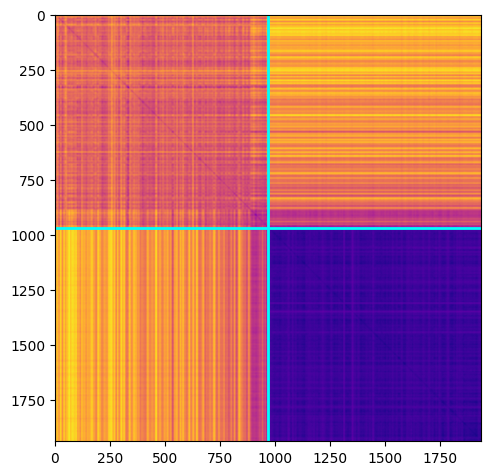

In [5]:
img = bottleneck.copy().astype(np.uint8)
img = ndimage.uniform_filter(img, size=9, mode='reflect')

fig, ax = plt.subplots(1,1, figsize=(5,5))
ax = np.atleast_1d(ax).ravel(); i = 0

ax[i].imshow(img, cmap='plasma')
ax[i].axhline(transfocus.shape[1], c='cyan', lw=2)
ax[i].axvline(transfocus.shape[1], c='cyan', lw=2)

fig.tight_layout();

In [6]:
mds_params = {'n_components':2, 'metric':True, 'random_state':42, 'dissimilarity':'precomputed', 'normalized_stress':False}
filename = dst + 'mds_{}_{}level_bottleneck.csv'.format(normtype, level)
if not os.path.isfile(filename):
    mds = manifold.MDS(**mds_params).fit_transform(bottleneck)
    pd.DataFrame(mds, columns=['x','y']).to_csv(filename, index = False)

mds = pd.read_csv(filename)
mds['gene'] = np.repeat(transcriptomes[tidxs], len(focus))
mds['cell.ID'] = np.tile(focus['Cell.ID..'].values, len(tidxs))

mx, Mx = mds['x'].min(), mds['x'].max()
my, My = mds['y'].min(), mds['y'].max()

mds.head()

,x,y,gene,cell.ID
0,-29.731586,-21.161243,GLYMA_05G092200,743
1,-21.434876,27.241306,GLYMA_05G092200,843
2,-35.996845,22.711790,GLYMA_05G092200,2053
3,-5.669490,16.010099,GLYMA_05G092200,1146
4,7.963405,18.168858,GLYMA_05G092200,896


In [7]:
diff = np.zeros(len(focus))
for j in range(len(diff)):
    diff[j] = bottleneck[j, j+len(focus)]

dmin, dmax = np.quantile(diff, [0.05, 0.95])
sdiff = np.argsort(diff)
rdiff = np.argsort(sdiff)
pd.Series(diff).describe()

count    968.000000
mean      47.695528
std       14.154155
min       13.935809
25%       37.837765
50%       47.020203
75%       57.056748
max      103.700880
dtype: float64

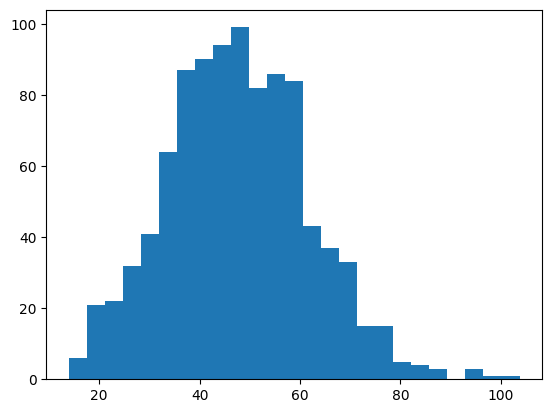

In [8]:
plt.hist(diff, bins=25);

In [9]:
kidx = 960
k = sdiff[kidx]
cidx = metafocus[k,0]
print(k, cidx, sep='\t')

PP = 10
ss = (np.s_[max([0, metacell.loc[cidx, 'y0'] - PP]) : min([wall.shape[0], metacell.loc[cidx, 'y1'] + PP])],
      np.s_[max([1, metacell.loc[cidx, 'x0'] - PP]) : min([wall.shape[1], metacell.loc[cidx, 'x1'] + PP])])
extent = (ss[1].start, ss[1].stop, ss[0].start, ss[0].stop)
cell = wall[ss].copy().astype(np.uint8)
cell[ label[ss] == cidx+1 ] = 2
cell[~wall[ss]] = 0

pxs = 75
cell[ -15:-5, 5:5 + pxs] = 0

300	2014


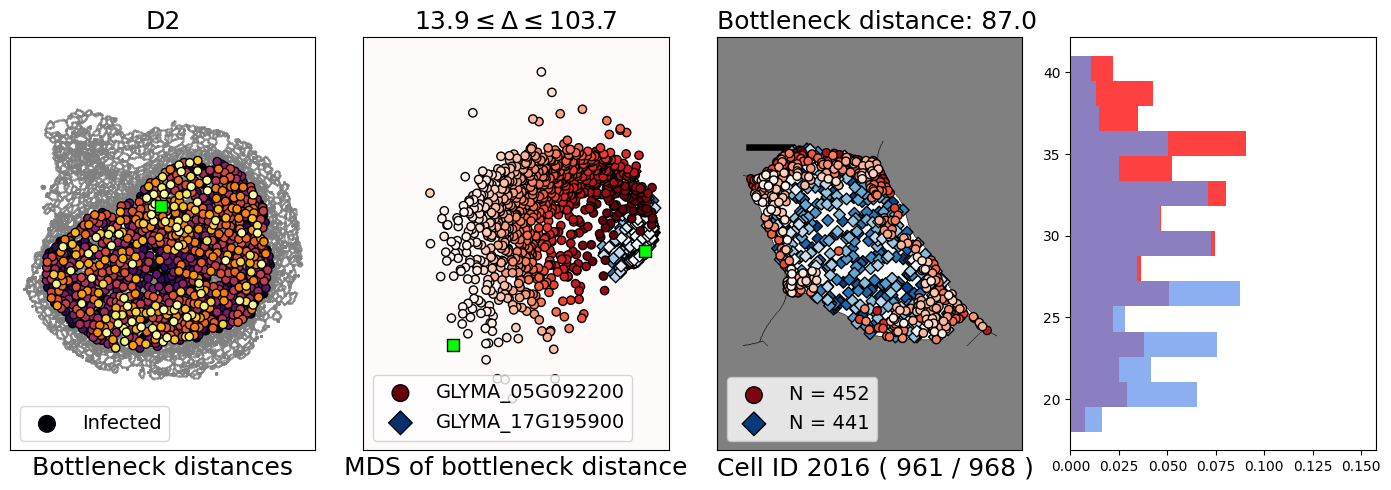

In [12]:
cmap = ['Reds_r', 'Blues_r']; shape = ['o', 'D']; color=['red','cornflowerblue']
fs = 18

krange = sdiff[:kidx+1]

fig, ax = plt.subplots(1,4, figsize=(14,5))
ax = np.atleast_1d(ax).ravel(); i = 0

ax[i].scatter(wc[1], wc[0], c='#808080', marker='.', s=0.5, zorder=1)
ax[i].scatter(metafocus[krange,13], metafocus[krange,14], c=diff[krange], vmin=dmin, vmax=dmax,
              cmap='inferno', marker='o', edgecolor='k', linewidth=1, label='Infected', zorder=2); 
ax[i].scatter(metafocus[k,13], metafocus[k,14], c='lime', s = 75,
              marker='s', edgecolor='k', linewidth=1, zorder=3); i+=1

for j in range(len(tidxs)):
    foo = mds[mds['gene'] == transcriptomes[tidxs[j]]].loc[:, ['x','y']].iloc[krange]
    ax[i].scatter(foo['x'], foo['y'], c=diff[krange], cmap=cmap[j], marker=shape[j], alpha=1,vmin=dmin, vmax=dmax,
                 edgecolor='k', linewidth=1, label=transcriptomes[tidxs[j]], zorder=len(tidxs)+1-j)
    ax[i].scatter(foo.iloc[-1,0], foo.iloc[-1,1], c='lime', marker='s', alpha=1, s = 75,
                 edgecolor='k', linewidth=1, zorder=len(tidxs)+5-j)

ax[i].scatter([mx, Mx], [my, My], color='snow')
ax[i].set_facecolor('snow'); i += 1

ax[i].imshow(cell, cmap='binary_r', origin='lower', extent=extent, vmin=0, vmax=2);
ax[i].set_facecolor('#808080')
if True:
    for j in range(len(tidxs)):
        coords = translocs[tidxs[j]].values.T
        cmask = label[ coords[1], coords[0] ] == cidx + 1
        ccoords = coords[:, cmask ].copy()
        zlevel = ccoords[2]
        ax[i].scatter(ccoords[0], ccoords[1], c=ccoords[2], cmap=cmap[j], marker=shape[j], zorder=5-j, alpha=1, 
                      vmin=zvmin, vmax=zvmax, edgecolor='k', label='N = {}'.format(len(ccoords[0])));
        ax[i+1].hist(ccoords[2], bins=zbins, orientation='horizontal', color=color[j], alpha=0.75, density=True)
        ax[i+1].scatter([0.15], [30], alpha=0)

for i in range(len(ax)-1):
    ax[i].legend(fontsize=fs-4, markerscale=2, loc='lower left');
    ax[i].set_aspect('equal', 'datalim')
    ax[i].tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)

#ax[-1].tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
ax[0].set_title(sample, fontsize=fs)
ax[1].set_title('${:.1f} \leq \Delta \leq {:.1f}$'.format(diff.min(), diff.max()), fontsize=fs)
ax[2].set_title('Bottleneck distance: {:.1f}'.format(diff[k]), loc='left', fontsize=fs)

ax[0].set_xlabel('Bottleneck distances', fontsize=fs)
ax[1].set_xlabel('MDS of bottleneck distance', fontsize=fs)
ax[2].set_xlabel('Cell ID {:04d} ( {:03d} / {:03d} )'.format(metacell.loc[cidx, 'orig_cellID'], kidx+1, len(diff)), loc='left', fontsize=fs)

fig.tight_layout()

In [13]:
kidx = 160
k = sdiff[kidx]
cidx = metafocus[k,0]
print(k, cidx, sep='\t')

PP = 10
ss = (np.s_[max([0, metacell.loc[cidx, 'y0'] - PP]) : min([wall.shape[0], metacell.loc[cidx, 'y1'] + PP])],
      np.s_[max([1, metacell.loc[cidx, 'x0'] - PP]) : min([wall.shape[1], metacell.loc[cidx, 'x1'] + PP])])
extent = (ss[1].start, ss[1].stop, ss[0].start, ss[0].stop)
cell = wall[ss].copy().astype(np.uint8)
cell[ label[ss] == cidx+1 ] = 2
cell[~wall[ss]] = 0

pxs = 75
cell[ -15:-5, 5:5 + pxs] = 0

351	368


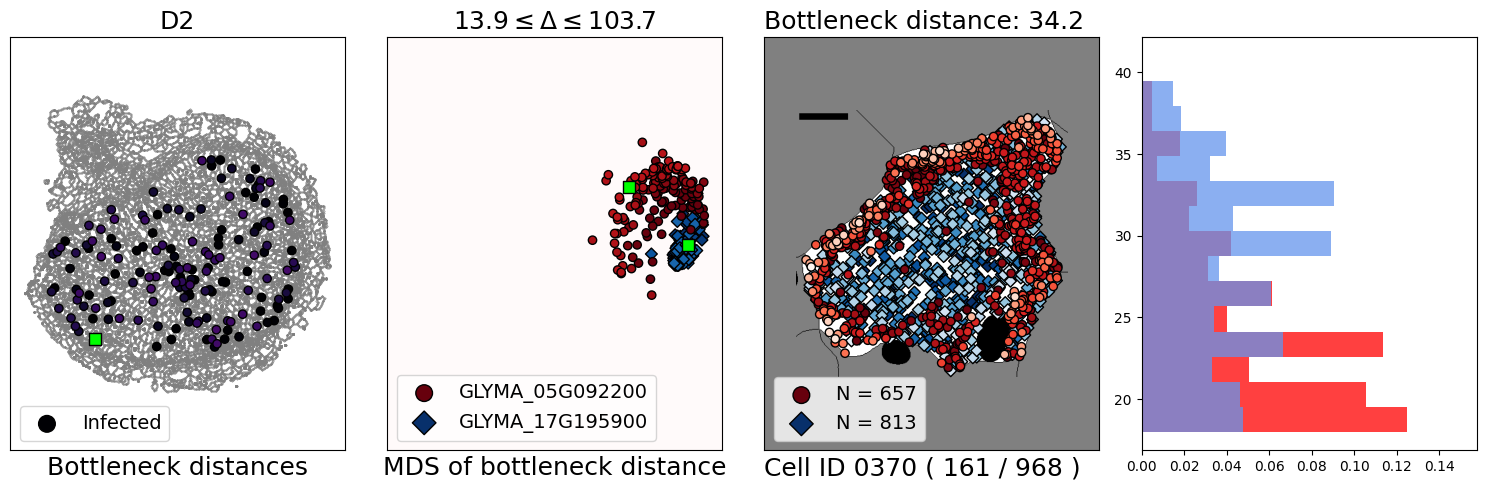

In [14]:
cmap = ['Reds_r', 'Blues_r']; shape = ['o', 'D']; color=['red','cornflowerblue']
fs = 18

krange = sdiff[:kidx+1]

fig, ax = plt.subplots(1,4, figsize=(15,5))
ax = np.atleast_1d(ax).ravel(); i = 0

ax[i].scatter(wc[1], wc[0], c='#808080', marker='.', s=0.5, zorder=1)
ax[i].scatter(metafocus[krange,13], metafocus[krange,14], c=diff[krange], vmin=dmin, vmax=dmax,
              cmap='inferno', marker='o', edgecolor='k', linewidth=1, label='Infected', zorder=2); 
ax[i].scatter(metafocus[k,13], metafocus[k,14], c='lime', s = 75,
              marker='s', edgecolor='k', linewidth=1, zorder=3); i+=1

for j in range(len(tidxs)):
    foo = mds[mds['gene'] == transcriptomes[tidxs[j]]].loc[:, ['x','y']].iloc[krange]
    ax[i].scatter(foo['x'], foo['y'], c=diff[krange], cmap=cmap[j], marker=shape[j], alpha=1,vmin=dmin, vmax=dmax,
                 edgecolor='k', linewidth=1, label=transcriptomes[tidxs[j]], zorder=len(tidxs)+1-j)
    ax[i].scatter(foo.iloc[-1,0], foo.iloc[-1,1], c='lime', marker='s', alpha=1, s = 75,
                 edgecolor='k', linewidth=1, zorder=len(tidxs)+5-j)

ax[i].scatter([mx, Mx], [my, My], color='snow')
ax[i].set_facecolor('snow'); i += 1

ax[i].imshow(cell, cmap='binary_r', origin='lower', extent=extent, vmin=0, vmax=2);
ax[i].set_facecolor('#808080')
if True:
    for j in range(len(tidxs)):
        coords = translocs[tidxs[j]].values.T
        cmask = label[ coords[1], coords[0] ] == cidx + 1
        ccoords = coords[:, cmask ].copy()
        zlevel = ccoords[2]
        ax[i].scatter(ccoords[0], ccoords[1], c=ccoords[2], cmap=cmap[j], marker=shape[j], zorder=5-j, alpha=1, 
                      vmin=zvmin, vmax=zvmax, edgecolor='k', label='N = {}'.format(len(ccoords[0])));
        ax[i+1].hist(ccoords[2], bins=zbins, orientation='horizontal', color=color[j], alpha=0.75, density=True)
        ax[i+1].scatter([0.15], [30], alpha=0)
        
for i in range(len(ax)-1):
    ax[i].legend(fontsize=fs-4, markerscale=2, loc='lower left');
    ax[i].set_aspect('equal', 'datalim')
    ax[i].tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)

ax[0].set_title(sample, fontsize=fs)
ax[1].set_title('${:.1f} \leq \Delta \leq {:.1f}$'.format(diff.min(), diff.max()), fontsize=fs)
ax[2].set_title('Bottleneck distance: {:.1f}'.format(diff[k]), loc='left', fontsize=fs)

ax[0].set_xlabel('Bottleneck distances', fontsize=fs)
ax[1].set_xlabel('MDS of bottleneck distance', fontsize=fs)
ax[2].set_xlabel('Cell ID {:04d} ( {:03d} / {:03d} )'.format(metacell.loc[cidx, 'orig_cellID'], kidx+1, len(diff)), loc='left', fontsize=fs)

fig.tight_layout()